In [128]:
# Imports
import warnings
warnings.simplefilter(action="ignore", category=(FutureWarning, DeprecationWarning))
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from statsmodels.tools.eval_measures import mse
np.random.seed(0)  # For reproducible results

In [97]:
def get_data(tickerSymbol, period, start, end):

    # Get data on the ticker
    tickerData = yf.Ticker(tickerSymbol)

    # Get the historical prices for this ticker
    tickerDf = tickerData.history(period=period, start=start, end=end)
    
    return tickerDf
    
def perform_adf_test(series, title, regression_type):
    out = adfuller(series, regression=regression_type)
    print(f"Results for {title}:")
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")

def hurst(ts):
        
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.var(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]/2.0

## Exercise 

- Download and plot the historical closing prices of Tesla (``TSLA``) and Equinor (``EQNR``) for the years ``2019-12-31``- ``2022-12-31``.
- For each time series:
    - Test if the time series look stationary.
    - Compute the Hurst coefficient for both time series.
    - Which stock would you like to invest into? Motivate your answer based on the tests and the value of $H$.
    - Simulate the stock prices using GBM.

- Which simulation seems to be more reliable? The one for Tesla or Equinor? 
- To motivate your answer: 
    1. compute the simulation at least 100 times.
    2. Compute the MSE between the true stock prices and the simulated ones.
    3. Compare the expected value of the MAPE for the two stocks.

### Points 1 + 2

- Point 1 is straightforward.
- From visual ispection, EQNR time series has a trend + costant shift. Is indeed not stationary, but it's residuals might be. We can try to apply the modified ADF test and tak einto acocunt both costant shift and seasonality to test the stationarity of residuals.
- TSLA on the other hand do not have a costant trend. The TS looks more like a random walk. It is also non stationary. 

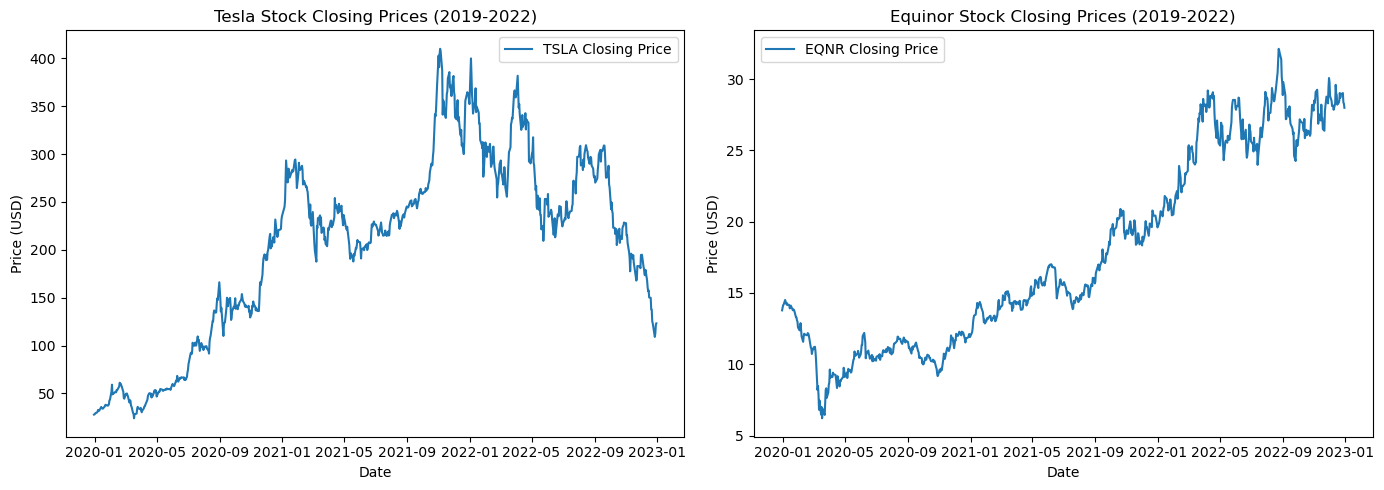

Results for Constant, No Trend:
ADF Statistic: -1.86
p-value: 0.349
Critical Values: ['1%: -3.44', '5%: -2.87', '10%: -2.57']

Results for Constant and Trend:
ADF Statistic: -3.60
p-value: 0.030
Critical Values: ['1%: -3.97', '5%: -3.42', '10%: -3.13']



In [98]:
tsla_data = get_data('TSLA', period='1d', start='2019-12-31', end='2022-12-31')
eqnr_data = get_data('EQNR', period='1d', start='2019-12-31', end='2022-12-31')

# Plotting the Closing Prices
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(tsla_data['Close'], label='TSLA Closing Price')
plt.title('Tesla Stock Closing Prices (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(eqnr_data['Close'], label='EQNR Closing Price')
plt.title('Equinor Stock Closing Prices (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

perform_adf_test(tsla_data['Close'], "Constant, No Trend", 'c')
perform_adf_test(eqnr_data['Close'], "Constant and Trend", 'ct')


ADF test confirms that the residuals of EQNR time series are stationary.
- Let us now ocmpute the hirst coefficients.

In [99]:
print('Hurst coefficient of TSLA:', hurst(tsla_data['Close'].to_numpy()))
print('Hurst coefficient of EQNR:', hurst(eqnr_data['Close'].to_numpy()))


Hurst coefficient of TSLA: 0.4626299151627128
Hurst coefficient of EQNR: 0.33155078536369803


- For TSLA, H ~ 0.5. This means that the time series behaves similarly to a random walk, meaning that future samples behaves almost independently with respect to past values. For this reason, I would not invest on this stock.
- For EQNR, H < 0.5, meaning that the time series is mean reverting. That said, the time series seems to be rising with a positive trend, looking more like a trending time series. 

H < 0.5 could mean that the time seires will eventually drop down to a lower mean, for this reason I would avoid investing in this stock as well.

Let's now simulate the stock prices using GBM. As test set, Let's try to use the year 2023 (even if not specified in the exercise):

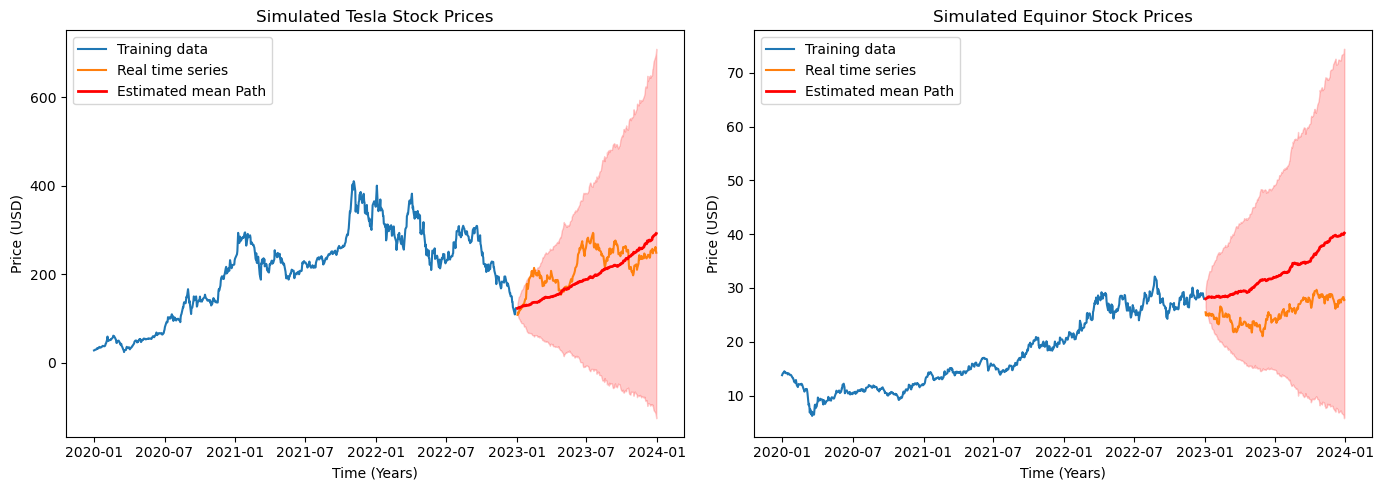

In [126]:
tsla_test = get_data('TSLA', period='1d', start='2022-12-31', end='2023-12-31')
eqnr_test = get_data('EQNR', period='1d', start='2022-12-31', end='2023-12-31')

# Compute mean and std on training data
T = 1  # Time horizon in years.
test_days = len(tsla_test)
dt = 1/(test_days)  # Time step in years.
N = int(T/dt)  # Number of time steps
time_step = np.linspace(0, T, N)
tsla_0 = tsla_data['Close'].iloc[-1] 
eqnr_0 = eqnr_data['Close'].iloc[-1] 
mu_tsla = tsla_data['Close'].pct_change().mean() * test_days  # Annualize the mean
sigma_tsla = tsla_data['Close'].pct_change().std() * np.sqrt(test_days)  # Annualize the std deviation
mu_enqr = eqnr_data['Close'].pct_change().mean() * test_days  # Annualize the mean
sigma_enqr = eqnr_data['Close'].pct_change().std() * np.sqrt(test_days)  # Annualize the std deviation

# Simulate the stock prices using Geometric Brownian Motion
# TESLA
n_paths = 100
paths_tsla = []
for _ in range(n_paths):
    W = np.cumsum(np.random.standard_normal(size=N))*np.sqrt(dt)
    X = (mu_tsla - 0.5 * sigma_tsla**2) * time_step + sigma_tsla * W
    paths_tsla.append(tsla_0 * np.exp(X))

tesla_path_mean = np.array(paths_tsla).mean(axis=0)
tesla_path_std = np.array(paths_tsla).std(axis=0)

# EQUINOR
paths_eqnr = []
for _ in range(n_paths):
    W = np.cumsum(np.random.standard_normal(size=N))*np.sqrt(dt)
    X = (mu_enqr - 0.5 * sigma_enqr**2) * time_step + sigma_enqr * W
    paths_eqnr.append(eqnr_0 * np.exp(X))

eqnr_path_mean = np.array(paths_eqnr).mean(axis=0)
eqnr_path_std = np.array(paths_eqnr).std(axis=0)
# Plotting the simulated paths
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(tsla_data['Close'], label='Training data')
plt.plot(tsla_test.index, tsla_test['Close'], label='Real time series')
plt.plot(tsla_test.index, tesla_path_mean, label='Estimated mean Path', color='red', linewidth=2)
plt.fill_between(tsla_test.index, tesla_path_mean-1.96*tesla_path_std, tesla_path_mean + +1.96*tesla_path_std, color='red', alpha=0.2)
plt.title('Simulated Tesla Stock Prices')
plt.xlabel('Time (Years)')
plt.ylabel('Price (USD)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eqnr_data['Close'], label='Training data')
plt.plot(eqnr_test.index, eqnr_test['Close'], label='Real time series')
plt.plot(eqnr_test.index, eqnr_path_mean, label='Estimated mean Path', color='red', linewidth=2)
plt.fill_between(eqnr_test.index, eqnr_path_mean-1.96*eqnr_path_std, eqnr_path_mean + +1.96*eqnr_path_std, color='red', alpha=0.2)
plt.title('Simulated Equinor Stock Prices')
plt.xlabel('Time (Years)')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()


In [129]:
tsla_mse = mse(tsla_test['Close'], tesla_path_mean)
eqnr_mse = mse(eqnr_test['Close'], eqnr_path_mean)

print(f"Mean Squared Error for TSLA: {tsla_mse:.2f}")
print(f"Mean Squared Error for EQNR: {eqnr_mse:.2f}")

tsla_mape = np.mean(np.abs((tsla_test['Close'] - tesla_path_mean) / tsla_test['Close']))
eqnr_mape = np.mean(np.abs((eqnr_test['Close'] - eqnr_path_mean) / eqnr_test['Close']))

print(f"Mean Absolute Percentage Error for TSLA: {tsla_mape:.2}")
print(f"Mean Absolute Percentage Error for EQNR: {eqnr_mape:.2}")

Mean Squared Error for TSLA: 1941.67
Mean Squared Error for EQNR: 60.47
Mean Absolute Percentage Error for TSLA: 0.17
Mean Absolute Percentage Error for EQNR: 0.29


The MSE for tsla is higher than for eqnr. Tihs is expected, since the absolute values of tsla stocks are much higher than those of eqnr.

Even if the tesla prediction looks more reliable on paper, let's not forget that the Hurst test suggested that tesla stocks are mostly similar to a random walk, which is intrinsecly unpredictable.

Also, there is a strange bias between the train and test set of the EQNR stocks, which is very hard to explain or predict. This has a negative impact on the MSE and MAPE. That said, the forecast correctly predicted the overall shape of the EQNR stocks in the test set.

For this reason, I would state that Equinor forecast is more reliable.